In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_theme(style='darkgrid')

# NYC Point of Interest dataset

### Import data removing duplicates by id

In [2]:
df = pd.read_csv(
    '../datasets/pois_all_info',
    sep='\t',
    header=0,
    dtype = {
        'amenity': str,
        'name': str,
        'shop': str,
        'public_transport': str,
        'highway': str,
    },
    index_col='@id'
)
# Drop all duplicated `@id`s
df = df[~df.index.duplicated(keep='first')]
# Drop all columns which belong to no category and have no name
df = df.dropna(how='all', subset=['amenity', 'name', 'shop', 'public_transport', 'highway'])
# Merge with list of NYC POIs
df = df.merge(
    right=pd.read_csv('../datasets/ny_municipality_pois_id.csv', header=None).drop_duplicates(),
    left_on='@id',
    right_on=0,
    how='inner',
    validate='1:1'
).drop(columns=[0])
df

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
4,42811266,node,40.704807,-73.772734,NaN,NaN,NaN,stop_position,NaN
...,...,...,...,...,...,...,...,...,...
43322,6625381551,node,40.736129,-73.746707,NaN,Springfield Boulevard & Union Turnpike,NaN,platform,bus_stop
43323,6625381552,node,40.735378,-73.748248,NaN,Union Turnpike & 222nd Street,NaN,platform,bus_stop
43324,6625381553,node,40.735450,-73.749046,NaN,Union Turnpike & 222nd Street,NaN,platform,bus_stop
43325,6625381554,node,40.735144,-73.750853,NaN,Union Turnpike & 220th Place,NaN,platform,bus_stop


### Missing Values

Notice that many columns are mostly made up of missing values

In [3]:
df.isnull().sum() / len(df)

@id                 0.000000
@type               0.000000
@lat                0.000000
@lon                0.000000
amenity             0.429986
name                0.294920
shop                0.798809
public_transport    0.806703
highway             0.825536
dtype: float64

In [4]:
(1 - df[['amenity', 'shop', 'public_transport', 'highway']].isnull().sum() / len(df))

amenity             0.570014
shop                0.201191
public_transport    0.193297
highway             0.174464
dtype: float64

Notice how some POIs belong to multiple categories

In [5]:
(1 - df[['amenity', 'shop', 'public_transport', 'highway']].isnull().sum() / len(df)).sum()

1.138966464329402

### Analyze POIs for each category

<AxesSubplot:ylabel='amenity'>

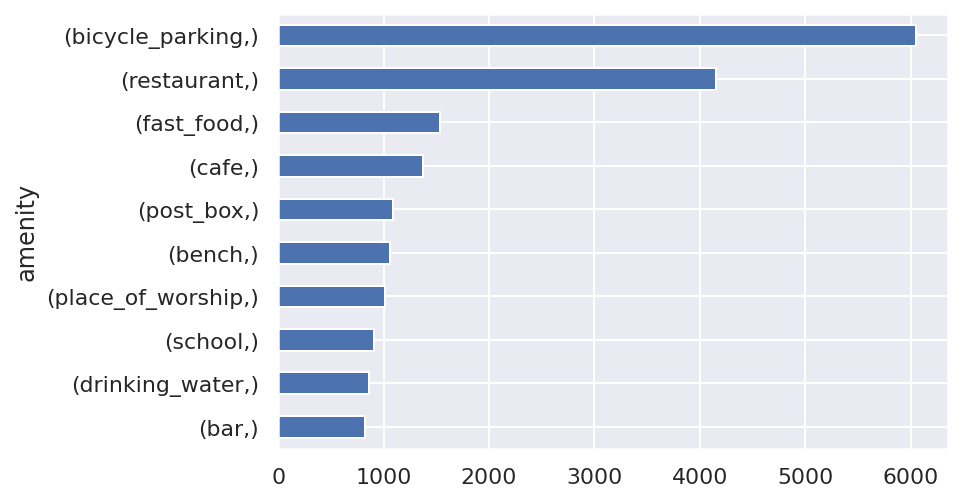

In [6]:
df[df['amenity'].notnull()][['amenity']].value_counts()[:10][::-1].plot(kind='barh')

<AxesSubplot:ylabel='shop'>

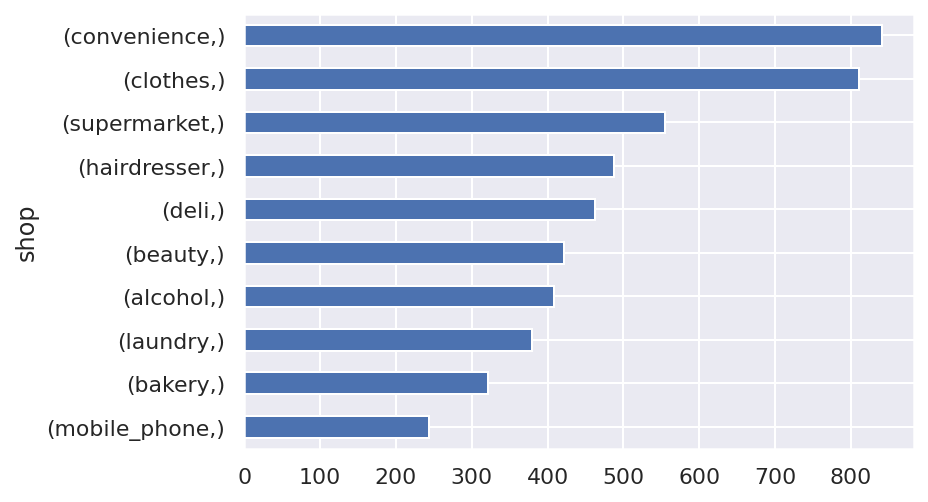

In [7]:
df[df['shop'].notnull()][['shop']].value_counts()[:10][::-1].plot(kind='barh')

<AxesSubplot:ylabel='public_transport'>

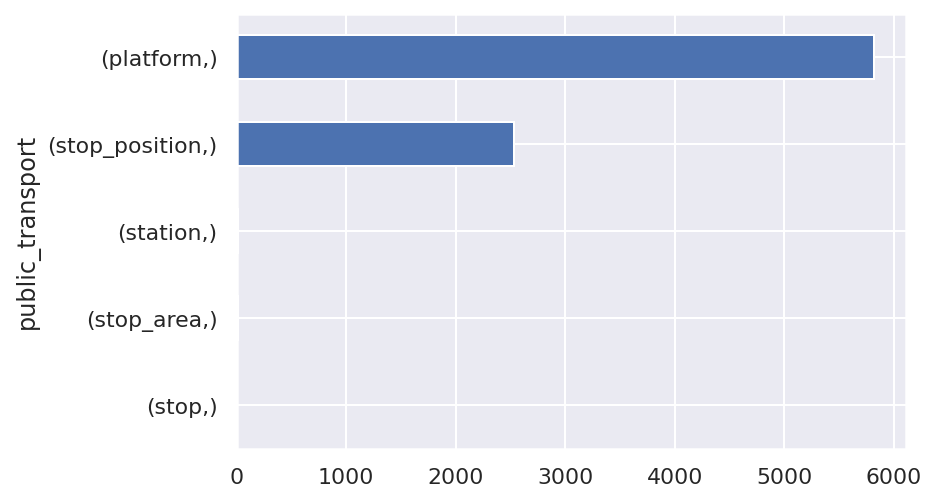

In [8]:
df[df['public_transport'].notnull()][['public_transport']].value_counts()[:10][::-1].plot(kind='barh')

<AxesSubplot:ylabel='highway'>

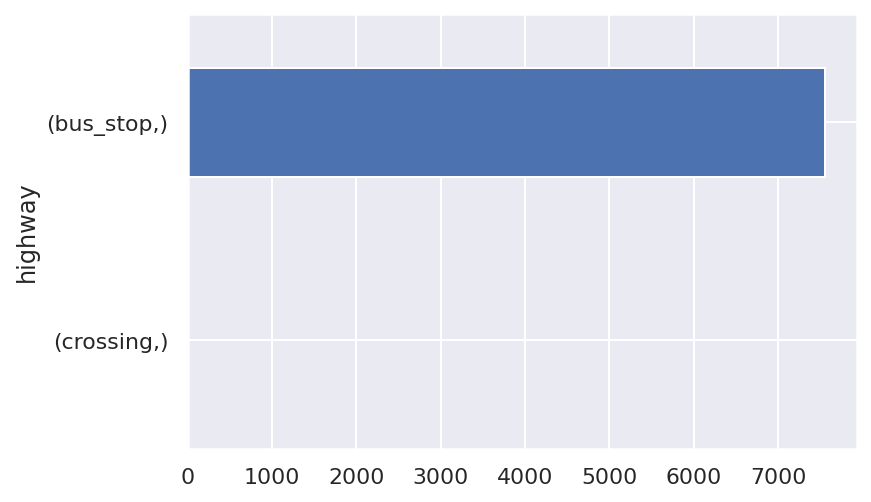

In [9]:
df[df['highway'].notnull()][['highway']].value_counts()[:10][::-1].plot(kind='barh')

### Plot POIs on a map

In [10]:
import geopandas

In [11]:
def plot_categories_over_map(category):    
    nybb = geopandas.read_file(geopandas.datasets.get_path('nybb'))
    ax = nybb.to_crs("EPSG:4326").plot()
    df_cat = df[df[category].notnull()]
    gdf = geopandas.GeoDataFrame(
        df_cat,
        geometry=geopandas.points_from_xy(
            df_cat['@lon'],
            df_cat['@lat']
        )
    )
    gdf['geometry'].plot(ax=ax, c='k')
    return ax

<AxesSubplot:>

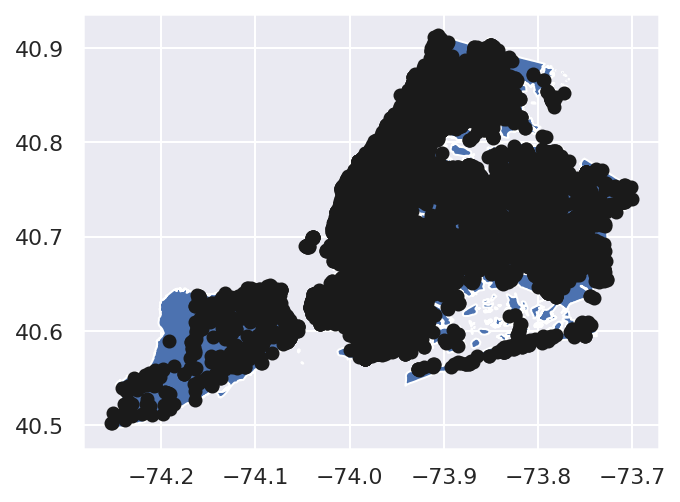

In [12]:
plot_categories_over_map('amenity')

<AxesSubplot:>

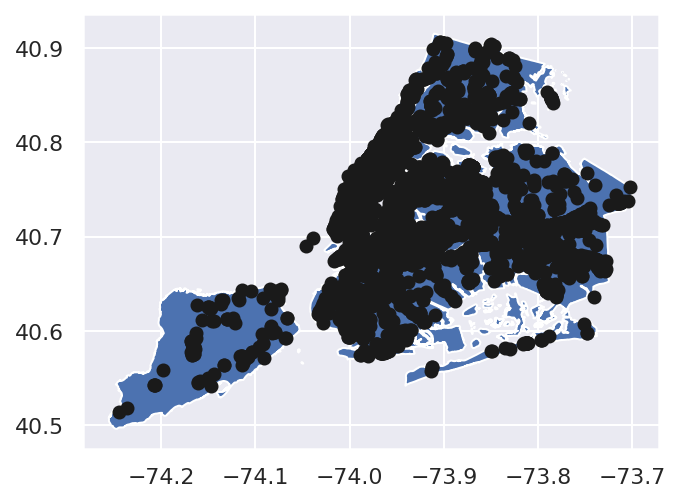

In [13]:
plot_categories_over_map('shop')

<AxesSubplot:>

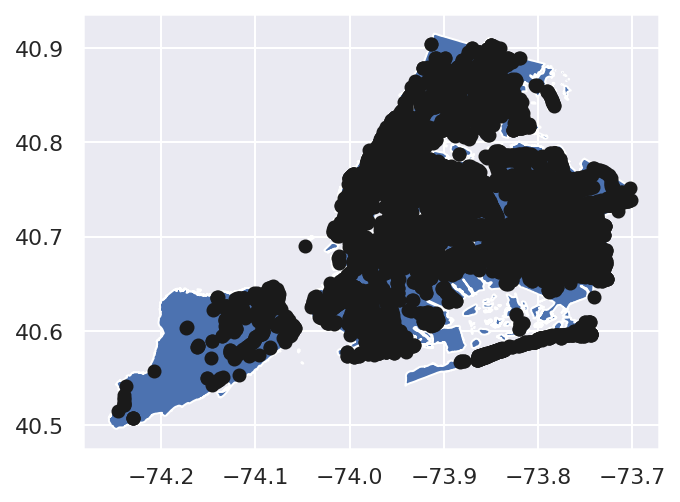

In [14]:
plot_categories_over_map('public_transport')

<AxesSubplot:>

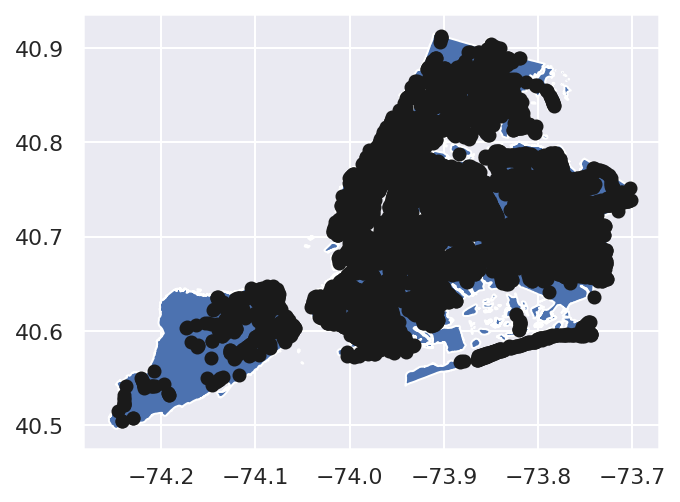

In [15]:
plot_categories_over_map('highway')

### POI position discretization

Discretize the POIs by geographical position. Define a new function (or class) that is able to split thegeographical position of the POIs using a grid. Once defined the grid over the New York municipality,the function has to assign each POI to the cell to which it belongs to. The result should be a PandasDataFrame with a new column containing the cell_id for each POI.

In [16]:
df['lon_bin'] = pd.cut(df['@lon'], bins=10).apply(lambda r: (r.mid))
df['lat_bin'] = pd.cut(df['@lat'], bins=10).apply(lambda r: (r.mid))
df

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway,lon_bin,lat_bin
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN,-73.9485,40.8110
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN,-73.9485,40.7695
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN,-73.7830,40.8525
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN,-73.8935,40.8525
4,42811266,node,40.704807,-73.772734,NaN,NaN,NaN,stop_position,NaN,-73.7830,40.6875
...,...,...,...,...,...,...,...,...,...,...,...
43322,6625381551,node,40.736129,-73.746707,NaN,Springfield Boulevard & Union Turnpike,NaN,platform,bus_stop,-73.7275,40.7285
43323,6625381552,node,40.735378,-73.748248,NaN,Union Turnpike & 222nd Street,NaN,platform,bus_stop,-73.7275,40.7285
43324,6625381553,node,40.735450,-73.749046,NaN,Union Turnpike & 222nd Street,NaN,platform,bus_stop,-73.7275,40.7285
43325,6625381554,node,40.735144,-73.750853,NaN,Union Turnpike & 220th Place,NaN,platform,bus_stop,-73.7275,40.7285


### Group by grid cells
Now you have to identify how many times a POI type is contained in each cell, for each category.Create a new DataFrame containing thecell_idas index, the POI types as columns and the countof the occurrences of each type, in each cell, as values.

In [30]:
df1 = df.groupby(['lat_bin', 'lon_bin'])[['amenity', 'shop' ,'public_transport', 'highway']].count().copy()
df1

amenity  shop  public_transport  \
lat_bin            lon_bin                                               
40.522999999999996 -74.2255               39.0   6.0              14.0   
                   -74.16999999999999     18.0   1.0               1.0   
                   -74.11449999999999      NaN   NaN               NaN   
                   -74.0595                NaN   NaN               NaN   
                   -74.00399999999999      NaN   NaN               NaN   
...                                        ...   ...               ...   
40.8935            -73.9485                1.0   0.0               3.0   
                   -73.8935              176.0  38.0              97.0   
                   -73.83850000000001    126.0  31.0             183.0   
                   -73.783                 NaN   NaN               NaN   
                   -73.72749999999999      NaN   NaN               NaN   

                                       highway  
lat_bin            lon_bin                      
40.522999999999996 -74.2255               24.0  
                   -74.16999999999999      5.0  
                   -74.11449999999999      NaN  
                   -74.0595                NaN  
                   -74.00399999999999      NaN  
...                                        ...  
40.8935            -73.9485                0.0  
                   -73.8935               65.0  
                   -73.83850000000001    129.0  
                   -73.783                 NaN  
                   -73.72749999999999      NaN  

[100 rows x 4 columns]

### Heatmaps
For the categoriesamenitiesandshopidentify if there exist a correlation between the location of dif-ferent POI types. Compute the pairwise correlation between the columns of the cell-type DataFrameand show it through a heatmap chart.

<AxesSubplot:xlabel='lon_bin', ylabel='lat_bin'>

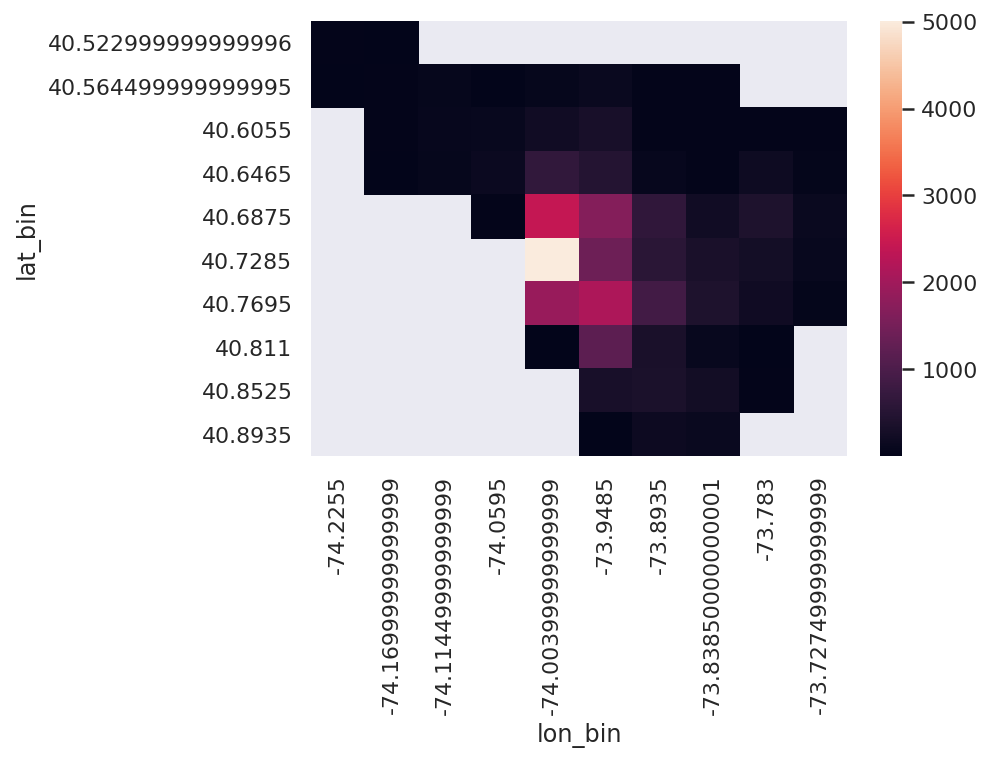

In [54]:
sns.heatmap(df1.reset_index().pivot('lat_bin', 'lon_bin', 'amenity'))

<AxesSubplot:xlabel='lon_bin', ylabel='lat_bin'>

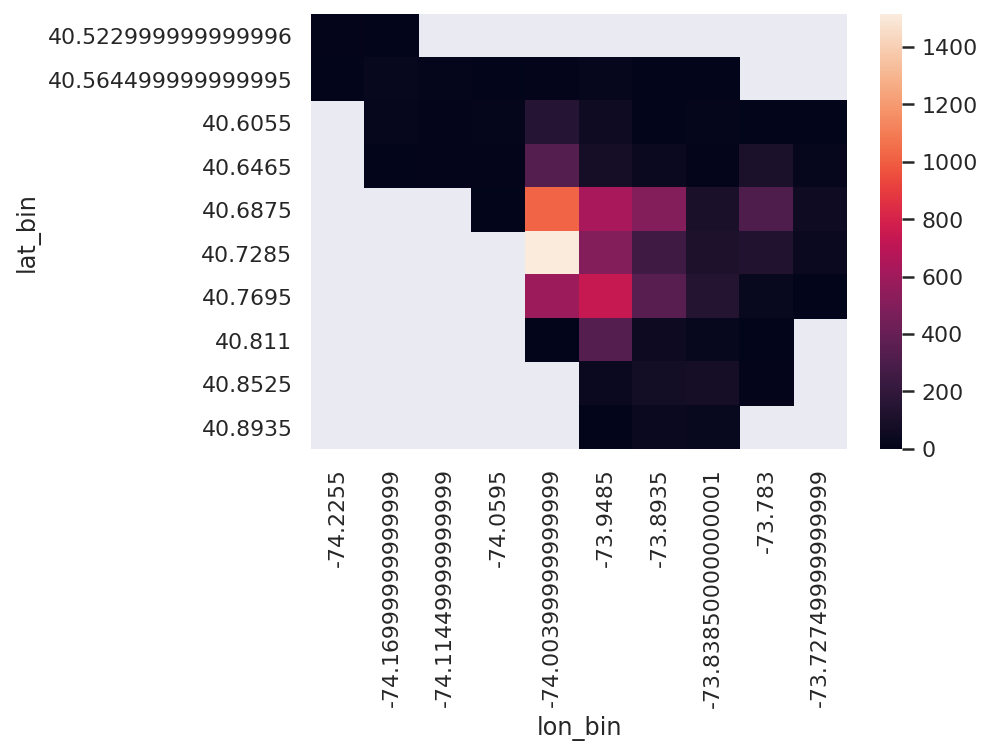

In [55]:
sns.heatmap(df1.reset_index().pivot('lat_bin', 'lon_bin', 'shop'))